In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from shapely.ops import unary_union

import matplotlib.pyplot as plt
import seaborn as sns

from libpysal.weights import Kernel
from esda.moran import Moran

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score, train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler

In [2]:
# set seaborn theme
sns.set_theme(style='darkgrid')

In [3]:
loc_gdf = gpd.read_file('data/AQMS_loc.shp')

# Initialise

In [ ]:
# set buffer zones around each site (1km)
loc_gdf['buffer_1km'] = loc_gdf['geometry'].buffer(1000)

In [ ]:
buffer_gdf = loc_gdf[['buffer_1km']]
buffer_gdf = gpd.GeoDataFrame(buffer_gdf, geometry='buffer_1km')
buffer_gdf.to_file('data/buffer.shp')

## gsp modify

In [ ]:
loc_gdf

0575 - LH0

1065, 1070, 1565, 1570 - TD5

2565, 2570, 3065, 3070 - CR8

2565, 3065 - ST5

2080, 2580 - KC1

2580, 2585 - CD1

2580 - MY7

2580, 3080 - BL0, CD9

3080 - CT2, CT3

3570, 3575 - HP1, LW2

3575, 3580, 4075, 4080 - GN6

3580 - TH4

4070, 4075, 4570, 4575 - GB0

4070, 4075 - GR9, GR4

4075, 4575 - GN3

5075 - BX9

5080 - HV1

In [ ]:
def readin_Gsp(file_name, path='data/OSMM Greenspaces/tq/TQ', suffix='_GreenspaceArea.shp'):
    if type(file_name) == str:
        gdf = gpd.read_file(path+file_name+suffix)
    else:
        gdf = pd.concat(gpd.read_file(path+f+suffix) for f in file_name)
    return gdf

In [ ]:
loc_gdf['Gsp'] = gpd.GeoSeries()

In [ ]:
loc_gdf.columns.get_loc('Gsp')

In [ ]:
def get_Gsp(file_name, index):
    gdf = readin_Gsp(file_name)
    print('Finish reading in shapefile(s)')
    shp = gdf['geometry'].unary_union
    print('Finish unary union.')
    if type(index) == int:
        loc_gdf.iat[index, 4] = shp.intersection(loc_gdf.loc[index, 'buffer_1km'])
    elif type(index) == list:
        for i in index:
            loc_gdf.iat[i, 4] = shp.intersection(loc_gdf.loc[i, 'buffer_1km'])
    else:
        print('invalid type!')

In [ ]:
get_Gsp('0575', 13)
loc_gdf.loc[13, 'Gsp']

In [ ]:
get_Gsp(['1065','1070','1565','1570'], 17)
loc_gdf.loc[17, 'Gsp']

In [ ]:
get_Gsp(['2565','2570','3065','3070'], 6)
loc_gdf.loc[6, 'Gsp']

In [ ]:
get_Gsp(['2565','3065'], 18)
loc_gdf.loc[18, 'Gsp']

In [ ]:
get_Gsp(['2080','2580'], 14)
loc_gdf.loc[14, 'Gsp']

In [ ]:
get_Gsp(['2580','2585'], 3)
loc_gdf.loc[3, 'Gsp']

In [ ]:
get_Gsp('2580', 20)
loc_gdf.loc[20, 'Gsp']

In [ ]:
get_Gsp(['2580','3080'], [1,2])

In [ ]:
loc_gdf.loc[1, 'Gsp']

In [ ]:
loc_gdf.loc[2, 'Gsp']

In [ ]:
get_Gsp('3080', [4,5])

In [ ]:
loc_gdf.loc[4, 'Gsp']

In [ ]:
loc_gdf.loc[5, 'Gsp']

In [ ]:
get_Gsp(['3570','3575'], [15,16])

In [ ]:
loc_gdf.loc[15, 'Gsp']

In [ ]:
loc_gdf.loc[16, 'Gsp']

In [ ]:
get_Gsp(['3575','3580','4075','4080'], 9)
loc_gdf.loc[9, 'Gsp']

In [ ]:
get_Gsp('3580', 19)
loc_gdf.loc[19, 'Gsp']

In [ ]:
get_Gsp(['4070','4075','4570','4575'], 8)
loc_gdf.loc[8, 'Gsp']

In [ ]:
get_Gsp(['4075', '4575'], [7, 11])

In [ ]:
loc_gdf.loc[7, 'Gsp']

In [ ]:
loc_gdf.loc[11, 'Gsp']

In [ ]:
get_Gsp(['4075', '4575'], 10)
loc_gdf.loc[10, 'Gsp']

In [ ]:
get_Gsp('5075', 0)
loc_gdf.loc[0, 'Gsp']

In [ ]:
get_Gsp('5080', 12)
loc_gdf.loc[12, 'Gsp']

In [ ]:
Gsp_gdf = loc_gdf[['siteid','Gsp']]
Gsp_gdf = Gsp_gdf.set_geometry('Gsp')
Gsp_gdf = Gsp_gdf.set_crs(27700)
Gsp_gdf.crs

In [ ]:
Gsp_gdf.to_file('data/gsp_buffer_1km.shp')

## nRd_gsp

In [ ]:
Gsp_gdf = gpd.read_file('data/gsp_buffer_1km.shp')

In [ ]:
Gsp_gdf.head()

In [ ]:
loc_gdf['Gsp'] = Gsp_gdf['geometry']
loc_gdf.info()

In [ ]:
del Gsp_gdf

In [ ]:
# Read in all the data
AQMS_df = pd.read_csv('data/hourly.csv')
Rd_gdf = gpd.read_file('data/london_Road.shp')
cond = pd.read_csv('data/cond_hourly.csv')

In [ ]:
Rd_gdf.head()

In [ ]:
for c in Rd_gdf['class'].unique():
    print('Number of ' + c + ': ', Rd_gdf[Rd_gdf['class'] == c].shape[0])

In [ ]:
# Get all types of roads
Rd = {}
for c in Rd_gdf['class'].unique():
    Rd[c] = Rd_gdf[Rd_gdf['class'] == c].loc[:, 'geometry'].unary_union
Rd

In [ ]:
Rd['Other'] = unary_union([Rd['Not Classified'], Rd['Unknown']])
Rd.pop('Not Classified')
Rd.pop('Unknown')
Rd

In [ ]:
del Rd_gdf

In [ ]:
for key in Rd.keys():
    loc_gdf[key] = loc_gdf['buffer_1km'].intersection(Rd[key])

loc_gdf.head()

In [ ]:
del Rd

In [ ]:
# Rename columns
loc_gdf.rename(columns={'Unclassified': 'UnC', 
                        'A Road': 'A',
                        'B Road': 'B',
                        'Classified Unnumbered': 'CUn',
                        'Motorway': 'Mt'}, inplace=True)

Rd_type = loc_gdf.columns[-6:]
Rd_type

In [ ]:
# Get all near-road green spaces
for col in Rd_type:
    loc_gdf['n'+col+'_Gsp'] = loc_gdf['Gsp'].intersection(loc_gdf[col].buffer(50))

loc_gdf.head()

In [ ]:
# london boundary read in
london = gpd.read_file('data/london_boundary.shp')

In [ ]:
# visualise all the sites on the map
fig,ax = plt.subplots(1, figsize=(15,13))

london.plot(color='lightgrey', ax=ax)
loc_gdf['buffer_1km'].plot(color='silver', ax=ax)
loc_gdf['geometry'].plot(markersize=10, marker='^', color='blue', 
                         label='Air quality monitoring site', ax=ax)

ax.axis('off')

legend=ax.legend(loc='best',shadow=True,fontsize=15)

#plt.savefig('sample1.png',facecolor='black',dpi=500)
plt.show()

There are some buffers that seem to be very close to each other.

In [ ]:
# add a column that specifies the shortest distance of a site to its nearest neighbour
loc_gdf['min_dis'] = pd.Series(dtype='float64')
for index, row in loc_gdf.iterrows():
    dis = []
    for i, v in loc_gdf['geometry'].iteritems():
        dis.append(row['geometry'].distance(v))
    dis.remove(0)
    loc_gdf.loc[index, 'min_dis'] = min(dis)

In [ ]:
# list sites that are close to each other (within 1.5km)
loc_gdf[loc_gdf['min_dis']<=1500]

In [ ]:
# check their readings' descriptive statistics
AQMS_df[AQMS_df['Site'].isin(['BL0', 'CD9', 'GR4', 'GB0'])].groupby('Site').describe()

In [ ]:
stats.ttest_rel(AQMS_df[AQMS_df['Site']=='BL0'].Value.values,
                AQMS_df[AQMS_df['Site']=='CD9'].Value.values)

In [ ]:
stats.ttest_rel(AQMS_df[AQMS_df['Site']=='GR4'].Value.values,
                AQMS_df[AQMS_df['Site']=='GB0'].Value.values)

Both indicate that we should reject H0, meaning the two datasets are statistically significantly different.

In [ ]:
# revmove them from the list
#loc_gdf.drop(['BL0','GR4'], inplace=True)

In [ ]:
# get areas and edge lengths of green spaces 
loc_gdf['Gsp_area'] = loc_gdf['Gsp'].area
loc_gdf['Gsp_edge'] = loc_gdf['Gsp'].length

In [ ]:
# get road lengths of each type and nRd gsp area percentages
for col in Rd_type:
    loc_gdf[col+'_len'] = loc_gdf[col].length
    loc_gdf['n'+col+'_Gsp_per_'+col+'_len'] = loc_gdf['n'+ col+'_Gsp'].area / loc_gdf[col+'_len']

In [ ]:
loc_gdf['Gsp_per_tRd_len'] = loc_gdf['Gsp_area'] / loc_gdf[[col+'_len' for col in Rd_type]].sum(axis=1)

In [ ]:
loc_gdf.info()

In [ ]:
# merge PM reading and site geogemetry data
df = pd.merge(AQMS_df, loc_gdf, left_on='Site', right_on='siteid')
df.info()

In [ ]:
# drop irrelevant columns
df.drop(['siteid', 'sitename', 'geometry', 'buffer_1km', 'Gsp', 'min_dis'], axis=1, inplace=True)
df.drop(Rd_type , axis=1, inplace=True)
df.drop(['n'+rd+'_Gsp' for rd in Rd_type], axis=1, inplace=True)
df.drop([rd+'_len' for rd in Rd_type], axis=1, inplace=True)

df.info()

There are many null values in `nMt_Gsp_per_Mt_len`.

Because only one site has near motorway.

Remove the variable would be the best.

In [ ]:
df.drop('nMt_Gsp_per_Mt_len', axis=1, inplace=True)

Some null values in `nB_Gsp_per_B_len` and `nCUn_Gsp_per_CUn_len`, which is due to the lengths of B roads or Classified Unnumbered roads in these buffers are zero.

In [ ]:
# set the null values to zero
df.fillna(0, inplace=True)
df.info()

In [ ]:
# merge with conditional variables
df = df.merge(cond, on='ReadingDateTime')
df.info()

In [ ]:
exp_names = df.columns[5:10].tolist()
exp_names

In [ ]:
var_names = exp_names + ['Gsp_edge', 'Gsp_per_tRd_len']
var_names

In [ ]:
cond_names = df.columns[-4:].tolist()
cond_names

In [ ]:
df[var_names + cond_names].describe()

In [ ]:
df.to_csv('temp_data.csv', index=False)

# Temporarily save

In [4]:
df = pd.read_csv('temp_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183960 entries, 0 to 183959
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Site                      183960 non-null  object 
 1   ReadingDateTime           183960 non-null  object 
 2   Value                     183960 non-null  float64
 3   Gsp_area                  183960 non-null  float64
 4   Gsp_edge                  183960 non-null  float64
 5   nUnC_Gsp_per_UnC_len      183960 non-null  float64
 6   nA_Gsp_per_A_len          183960 non-null  float64
 7   nB_Gsp_per_B_len          183960 non-null  float64
 8   nCUn_Gsp_per_CUn_len      183960 non-null  float64
 9   nOther_Gsp_per_Other_len  183960 non-null  float64
 10  Gsp_per_tRd_len           183960 non-null  float64
 11  bp_mean                   183960 non-null  float64
 12  tmp_mean                  183960 non-null  float64
 13  prec_mean                 183960 non-null  f

In [5]:
# covert the DateTime column to numpy.datetime variable
df['ReadingDateTime'] = pd.to_datetime(df['ReadingDateTime'], format="%d/%m/%Y %H:%M")
df.rename(columns={'ReadingDateTime':'DateTime'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183960 entries, 0 to 183959
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Site                      183960 non-null  object        
 1   DateTime                  183960 non-null  datetime64[ns]
 2   Value                     183960 non-null  float64       
 3   Gsp_area                  183960 non-null  float64       
 4   Gsp_edge                  183960 non-null  float64       
 5   nUnC_Gsp_per_UnC_len      183960 non-null  float64       
 6   nA_Gsp_per_A_len          183960 non-null  float64       
 7   nB_Gsp_per_B_len          183960 non-null  float64       
 8   nCUn_Gsp_per_CUn_len      183960 non-null  float64       
 9   nOther_Gsp_per_Other_len  183960 non-null  float64       
 10  Gsp_per_tRd_len           183960 non-null  float64       
 11  bp_mean                   183960 non-null  float64       
 12  tm

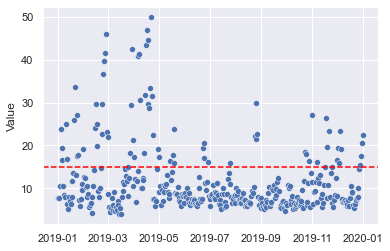

In [6]:
df['Date'] = df['DateTime'].dt.date

sns.scatterplot(x=df['Date'].unique(), y=df.groupby('Date').mean()['Value'])

plt.axhline(y=15, color='red', linestyle='--')
plt.show()

In [7]:
# number of date above WHO guideline
(df.groupby('Date').mean()['Value']>15).sum()

74

In [8]:
# annual mean for each site
df.groupby('Site').mean()['Value']

Site
BL0    10.908521
BX9    11.170749
CD1    11.058464
CD9    13.712563
CR8    10.125421
CT2    13.902287
CT3    12.142583
GB0    12.569166
GN3    13.363480
GN6    11.039737
GR4    10.887037
GR9    10.482015
HP1     9.931490
HV1    11.368690
KC1     9.567551
LH0     9.412646
LW2    15.422345
MY7    14.190663
ST5    11.732403
TD5    11.686217
TH4    12.610338
Name: Value, dtype: float64

In [9]:
exp_names = df.columns[5:10].tolist()
var_names = exp_names + ['Gsp_edge', 'Gsp_per_tRd_len']
cond_names = df.columns[11:15].tolist()

In [10]:
loc_gdf = loc_gdf.set_index('siteid')
loc_gdf = pd.merge(df.groupby('Site').mean()[var_names], loc_gdf, left_index=True, right_index=True)

In [11]:
# kernel weight matrix for the sites
weight = Kernel.from_dataframe(loc_gdf, geom_col='geometry', function='gaussian')

In [12]:
for var in var_names:
    moran_temp = Moran(loc_gdf[var].values, weight)
    print("Global Moran's I for " + var + ' is ', round(moran_temp.I, 5), 
          ' p-value: ', round(moran_temp.p_norm, 5))

Global Moran's I for nUnC_Gsp_per_UnC_len is  0.22651  p-value:  0.0
Global Moran's I for nA_Gsp_per_A_len is  0.1898  p-value:  4e-05
Global Moran's I for nB_Gsp_per_B_len is  0.02886  p-value:  0.17844
Global Moran's I for nCUn_Gsp_per_CUn_len is  0.15787  p-value:  0.00039
Global Moran's I for nOther_Gsp_per_Other_len is  0.19556  p-value:  3e-05
Global Moran's I for Gsp_edge is  0.02049  p-value:  0.22909
Global Moran's I for Gsp_per_tRd_len is  0.24583  p-value:  0.0


<AxesSubplot:>

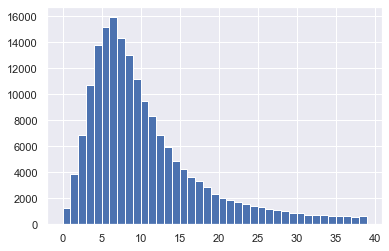

In [13]:
df['Value'].hist(bins=list(range(40)))

<AxesSubplot:>

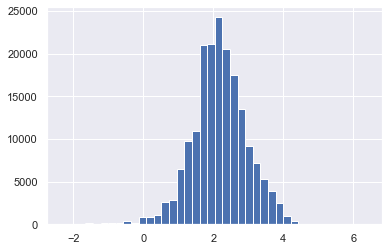

In [14]:
df['log_Value'] = np.log(df['Value'])
df['log_Value'].hist(bins=40)

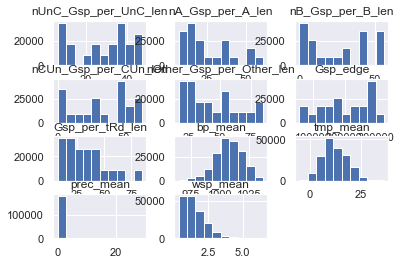

In [15]:
df[var_names + cond_names].hist(bins=10)
plt.show()

In [16]:
t_exp_names = exp_names.copy()
t_var_names = var_names.copy()

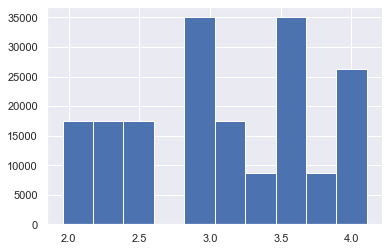

In [17]:
plt.hist(np.log(df['nA_Gsp_per_A_len']))
plt.show()

In [18]:
df['log_nA_Gsp_per_A_len'] = np.log(df['nA_Gsp_per_A_len'])
t_exp_names[1] = 'log_nA_Gsp_per_A_len'
t_var_names[1] = 'log_nA_Gsp_per_A_len'

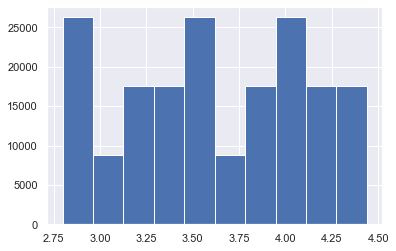

In [25]:
plt.hist(np.log(df['nOther_Gsp_per_Other_len']))
plt.show()

In [26]:
df['log_nOther_Gsp_per_Other_len'] = np.log(df['nOther_Gsp_per_Other_len'])
t_exp_names[4] = 'log_nOther_Gsp_per_Other_len'
t_var_names[4] = 'log_nOther_Gsp_per_Other_len'

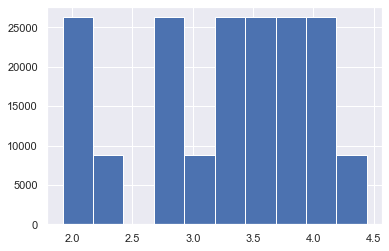

In [30]:
plt.hist(np.log(df['Gsp_per_tRd_len']))
plt.show()

In [31]:
df['log_Gsp_per_tRd_len'] = np.log(df['Gsp_per_tRd_len'])
t_var_names[6] = 'log_Gsp_per_tRd_len'

In [33]:
(df['prec_mean']>0).sum()/21

629.0

There is 629 out of 8760 hours in 2019 recorded raining, which is only around 7% of the time. Hence it would be better to use a categorical data (0 being not raining and 1 being raining) to represent the weather.

In [34]:
df['prec_mean'] = (df['prec_mean']>0).astype(int)
df['prec_mean'].sum()/21

629.0

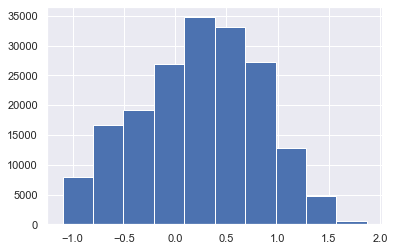

In [35]:
plt.hist(np.log(df['wsp_mean']))
plt.show()

In [36]:
df['log_wsp_mean'] = np.log(df['wsp_mean'])
cond_names[-1] = 'log_wsp_mean'

<AxesSubplot:xlabel='hour'>

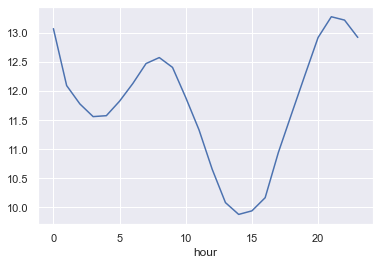

In [37]:
df['hour'] = df['DateTime'].dt.hour
df.groupby('hour').mean()['Value'].plot()

<AxesSubplot:xlabel='dayofweek'>

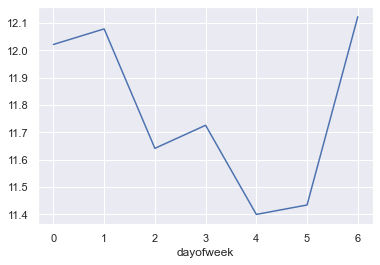

In [38]:
df['dayofweek'] = df['DateTime'].dt.dayofweek
df.groupby('dayofweek').mean()['Value'].plot()

<AxesSubplot:xlabel='dayofmonth'>

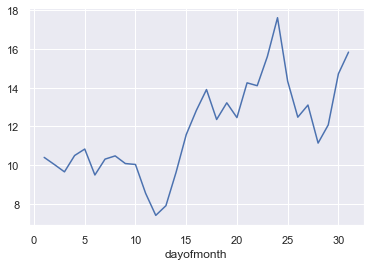

In [39]:
df['dayofmonth'] = df['DateTime'].dt.day
df.groupby('dayofmonth').mean()['Value'].plot()

In [40]:
def get_importance(reg, features, target, feature_names, rep=50, method='r2'):
    mean = []
    std = []
    importance = permutation_importance(reg, features, target, n_repeats=rep,
                                        random_state=25, scoring=method)
    for i in range(len(feature_names)):
        mean.append(round(importance.importances_mean[i], 5))
        std.append(round(importance.importances_std[i], 5))
    return mean, std

In [41]:
def get_cv_score(reg, features, target, iter=50, split=10, method='r2'):
    score = []
    for i in range(iter):
        kf = KFold(n_splits=split, shuffle=True, random_state=i)
        cv = cross_val_score(reg, features, target, cv=kf, scoring=method).tolist()
        score = score + cv
    
    return (np.mean(score), np.std(score))

In [42]:
scaler = MinMaxScaler()

In [43]:
reg = LinearRegression()
t_var = t_var_names + cond_names

ap_X = df[t_var].values
ap_y = df['log_Value'].values

ap_X_train, ap_X_test, ap_y_train, ap_y_test = train_test_split(ap_X, ap_y, 
                                                                shuffle=True, 
                                                                random_state=25)

ap_X_train = scaler.fit_transform(ap_X_train)
ap_X_test = scaler.fit_transform(ap_X_test)

reg.fit(ap_X_train, ap_y_train)

get_importance(reg, ap_X_test, ap_y_test, t_var)

([0.04082,
  6e-05,
  0.04713,
  0.03623,
  0.00736,
  0.00501,
  -0.0,
  0.0485,
  0.01709,
  0.00213,
  0.17155],
 [0.00137,
  8e-05,
  0.00161,
  0.0012,
  0.00067,
  0.00048,
  1e-05,
  0.00156,
  0.00085,
  0.0003,
  0.0028])

In [44]:
reg.score(ap_X_test, ap_y_test)

0.1782405669452879

In [ ]:
moran = []
for time in df['DateTime'].unique():
    moran_temp = Moran(df[df['DateTime']==time].log_Value.values, weight)
    moran.append([round(moran_temp.I, 5), round(moran_temp.p_norm, 5)])
moran_df = pd.DataFrame(df['DateTime'].unique(), columns=['DateTime'])
moran_df[['moran', 'p-value']] = moran
moran_df.head()

In [ ]:
moran_df['hour'] = moran_df['DateTime'].dt.hour

In [ ]:
fig,ax = plt.subplots(4, 6, figsize=(24,16))
i = 0
for hour in range(24):
    sns.lineplot(x=moran_df['DateTime'].dt.date.unique(), 
                 y=moran_df[moran_df['hour']==hour].moran.values, 
                 ax=ax[i//6, i%6], linewidth=1)
    i+=1
plt.show()

In [45]:
h_fi = []
h_score = []
h_coef = []
for hour in df['hour'].unique():
    X = df[df['hour']==hour].loc[:,t_var].values
    y = df[df['hour']==hour].loc[:,'log_Value'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=25)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    reg.fit(X_train, y_train)
    
    fi_mean, fi_std = get_importance(reg, X_test, y_test, feature_names=t_var)
    h_fi.append(fi_mean + fi_std)
    
    h_score.append(reg.score(X_test, y_test))
    
    coef = reg.coef_.tolist()
    coef.append(reg.intercept_)
    h_coef.append(coef)
    
h_fi = pd.DataFrame(h_fi, columns=['fi_' + elem for elem in t_var] + ['fi_std_' + elem for elem in t_var])
h_score = pd.DataFrame(h_score, columns=['r2'])
h_coef = pd.DataFrame(h_coef, columns=t_var+['intercept'])

In [46]:
h_reg = pd.concat([h_coef, h_score, h_fi], axis=1)
h_reg

,nUnC_Gsp_per_UnC_len,log_nA_Gsp_per_A_len,nB_Gsp_per_B_len,nCUn_Gsp_per_CUn_len,log_nOther_Gsp_per_Other_len,Gsp_edge,log_Gsp_per_tRd_len,bp_mean,tmp_mean,prec_mean,...,fi_std_log_nA_Gsp_per_A_len,fi_std_nB_Gsp_per_B_len,fi_std_nCUn_Gsp_per_CUn_len,fi_std_log_nOther_Gsp_per_Other_len,fi_std_Gsp_edge,fi_std_log_Gsp_per_tRd_len,fi_std_bp_mean,fi_std_tmp_mean,fi_std_prec_mean,fi_std_log_wsp_mean
0,-0.358787,0.338962,0.348936,0.462064,-0.119844,-0.400228,-0.485013,0.547079,-1.053581,0.015624,...,0.00520,0.00602,0.00793,0.00164,0.00524,0.00636,0.00499,0.00886,0.00022,0.01611
1,-0.397899,0.226976,0.264084,0.330237,-0.061456,-0.217848,-0.087748,0.628897,-0.942730,0.014084,...,0.00322,0.00444,0.00535,0.00085,0.00270,0.00102,0.00493,0.00703,0.00016,0.01375
2,-0.439841,0.301816,0.268494,0.384101,-0.029276,-0.253295,-0.172884,0.663554,-0.890743,-0.088759,...,0.00456,0.00486,0.00561,0.00035,0.00301,0.00204,0.00507,0.00687,0.00119,0.01429
3,-0.389777,0.218225,0.288239,0.361754,-0.031109,-0.249220,-0.139387,0.749112,-0.823124,-0.030686,...,0.00341,0.00560,0.00536,0.00045,0.00339,0.00167,0.00641,0.00688,0.00034,0.01368
4,-0.370637,0.122503,0.266540,0.357871,-0.138108,-0.153770,0.015548,0.750031,-0.814156,0.087850,...,0.00184,0.00495,0.00536,0.00190,0.00194,0.00019,0.00569,0.00653,0.00125,0.01337
5,-0.208215,0.015475,0.307082,0.312907,-0.197817,-0.174776,0.022954,0.588389,-0.714484,-0.291256,...,0.00026,0.00571,0.00473,0.00280,0.00212,0.00032,0.00437,0.00608,0.00325,0.01368
6,-0.080720,-0.185601,0.334158,0.202611,-0.192250,-0.183876,0.065124,0.654987,-0.540849,-0.251479,...,0.00303,0.00591,0.00302,0.00292,0.00233,0.00097,0.00492,0.00452,0.00273,0.01225
7,-0.098482,-0.262250,0.368162,0.243513,-0.307746,-0.143212,0.138760,0.608978,-0.420047,-0.496515,...,0.00424,0.00703,0.00350,0.00471,0.00170,0.00199,0.00563,0.00407,0.00626,0.01496
8,-0.173278,-0.194914,0.383844,0.285388,-0.198868,-0.233112,-0.041439,0.614002,-0.325245,-0.261690,...,0.00309,0.00761,0.00409,0.00295,0.00288,0.00059,0.00581,0.00292,0.00391,0.01619
9,-0.284720,-0.109375,0.383225,0.362687,-0.182108,-0.262245,-0.130316,0.541627,-0.430376,-0.036747,...,0.00170,0.00786,0.00561,0.00275,0.00326,0.00174,0.00521,0.00357,0.00040,0.01801


<AxesSubplot:>

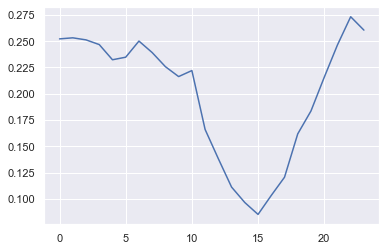

In [47]:
h_reg['r2'].plot()

No handles with labels found to put in legend.


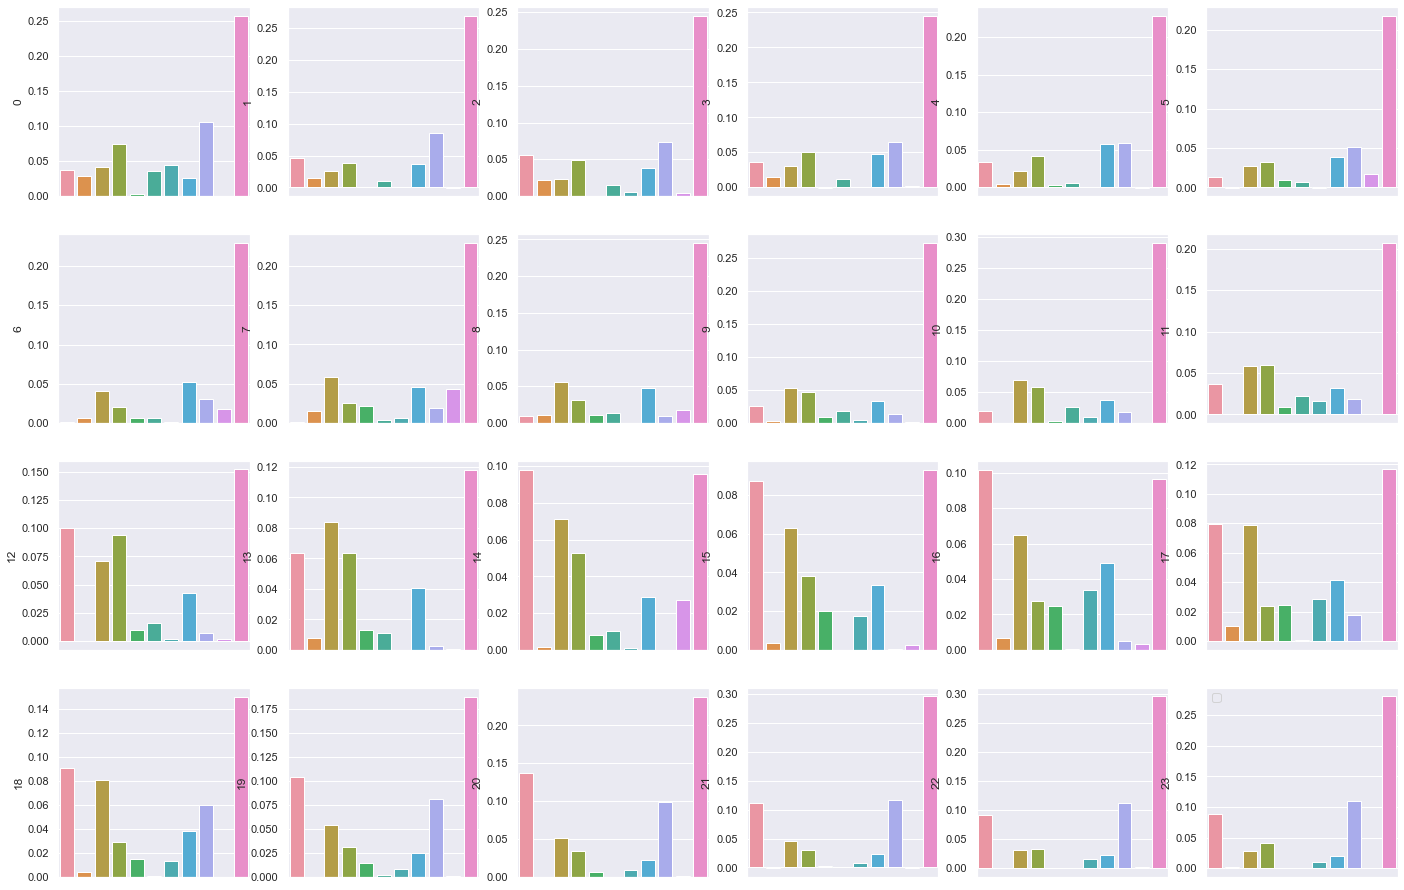

In [48]:
fig, ax = plt.subplots(4, 6, figsize=(24, 16))
i = 0
for hour in range(24):
    g = sns.barplot(x=['fi_' + elem for elem in t_var], y=h_reg.loc[hour, ['fi_' + elem for elem in t_var]],
                    ax=ax[i//6, i%6])
    g.set(xticklabels=[])
    i += 1
plt.legend()
plt.show()

In [49]:
# set up a new column for month information
df['month'] = df['DateTime'].dt.month

In [ ]:
moran_df['month'] = moran_df['DateTime'].dt.month

In [ ]:
fig,ax = plt.subplots(3, 4, figsize=(16,12))
i = 0
for month in range(1,13):
    sns.lineplot(x='DateTime', y='moran', data=moran_df[moran_df['month']==month],
                 ax=ax[i//4, i%4], linewidth=1)
    i+=1
plt.show()

In [50]:
m_fi = []
m_score = []
m_coef = []
for month in df['month'].unique():
    X = df[df['month']==month].loc[:, t_var].values
    y = df[df['month']==month].loc[:, 'log_Value'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=25)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    reg.fit(X_train, y_train)
    
    fi_mean, fi_std = get_importance(reg, X_test, y_test, feature_names=t_var)
    m_fi.append(fi_mean + fi_std)

    m_score.append(reg.score(X_test, y_test))
    
    coef = reg.coef_.tolist()
    coef.append(reg.intercept_)
    m_coef.append(coef)
    
m_fi = pd.DataFrame(m_fi, columns=['fi_' + elem for elem in t_var] + ['fi_std_' + elem for elem in t_var])
m_score = pd.DataFrame(m_score, columns=['r2'])
m_coef = pd.DataFrame(m_coef, columns=t_var+['intercept'])

In [51]:
m_reg = pd.concat([m_coef, m_score, m_fi], axis=1)
m_reg

,nUnC_Gsp_per_UnC_len,log_nA_Gsp_per_A_len,nB_Gsp_per_B_len,nCUn_Gsp_per_CUn_len,log_nOther_Gsp_per_Other_len,Gsp_edge,log_Gsp_per_tRd_len,bp_mean,tmp_mean,prec_mean,...,fi_std_log_nA_Gsp_per_A_len,fi_std_nB_Gsp_per_B_len,fi_std_nCUn_Gsp_per_CUn_len,fi_std_log_nOther_Gsp_per_Other_len,fi_std_Gsp_edge,fi_std_log_Gsp_per_tRd_len,fi_std_bp_mean,fi_std_tmp_mean,fi_std_prec_mean,fi_std_log_wsp_mean
0,-0.549553,0.070998,0.131326,0.234798,-0.032913,0.146786,0.156776,0.225886,-0.743126,-0.124549,...,0.00070,0.00155,0.00277,0.00033,0.00131,0.00152,0.00216,0.00482,0.00067,0.01289
1,-0.503883,-0.360826,0.163008,0.206304,0.212991,-0.068490,0.222233,0.690277,0.684386,0.085404,...,0.00332,0.00175,0.00245,0.00197,0.00064,0.00181,0.00491,0.00361,0.00074,0.01555
2,-1.077885,-0.084888,0.281002,0.420661,0.341815,-0.155153,0.383584,0.226684,1.271920,-0.356548,...,0.00081,0.00319,0.00511,0.00383,0.00164,0.00339,0.00155,0.00546,0.00292,0.01446
3,-0.497326,0.263414,-0.000510,0.065055,0.022750,0.161715,0.125052,0.400513,1.658598,0.015844,...,0.00253,0.00001,0.00065,0.00019,0.00133,0.00112,0.00415,0.01357,0.00007,0.01660
4,-0.759143,0.172987,0.224210,0.380734,-0.076297,-0.111099,0.171539,-0.265876,0.268333,-0.067123,...,0.00275,0.00399,0.00609,0.00122,0.00174,0.00213,0.00260,0.00299,0.00079,0.01300
5,-0.443838,0.347739,0.543394,0.336924,-0.422674,-0.463601,-0.079177,0.166290,1.261157,0.158477,...,0.00527,0.00717,0.00547,0.00672,0.00637,0.00115,0.00168,0.01095,0.00221,0.00771
6,-0.149820,-0.072241,0.511485,0.399461,-0.310191,-0.436759,-0.133573,-0.189118,1.401508,-0.024218,...,0.00105,0.00938,0.00760,0.00469,0.00667,0.00188,0.00235,0.01175,0.00042,0.00962
7,-0.069550,-0.078667,0.570754,0.278718,-0.342056,-0.367726,-0.159081,0.027016,1.306554,0.255713,...,0.00099,0.01001,0.00391,0.00437,0.00398,0.00180,0.00028,0.01185,0.00276,0.01772
8,0.108662,0.027588,0.284428,0.309949,-0.549986,-0.101137,-0.183707,0.039767,0.588003,0.060359,...,0.00034,0.00529,0.00512,0.00740,0.00120,0.00224,0.00048,0.00552,0.00029,0.01365
9,-0.004776,0.011316,0.210381,0.270118,-0.327292,0.001546,-0.284553,0.493131,0.001057,0.120412,...,0.00011,0.00288,0.00350,0.00434,0.00002,0.00289,0.00554,0.00001,0.00062,0.00676


<AxesSubplot:>

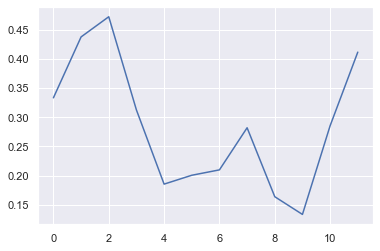

In [52]:
m_reg['r2'].plot()

No handles with labels found to put in legend.


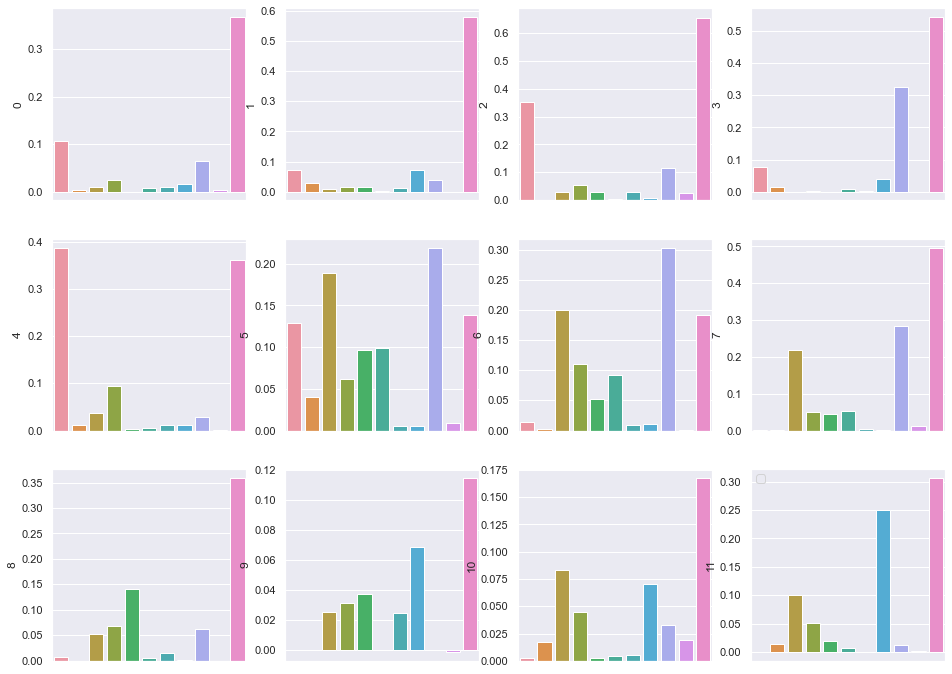

In [53]:
fig, ax = plt.subplots(3, 4, figsize=(16, 12))
i = 0
for month in range(1,13):
    g = sns.barplot(x=['fi_' + elem for elem in t_var], y=m_reg.loc[month-1, ['fi_' + elem for elem in t_var]],
                    ax=ax[i//4, i%4])
    g.set(xticklabels=[])
    i += 1
plt.legend()
plt.show()

<AxesSubplot:xlabel='month'>

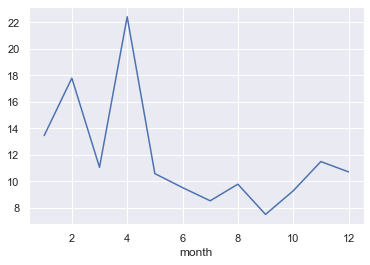

In [54]:
df.groupby('month').mean()['Value'].plot()

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183960 entries, 0 to 183959
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Site                          183960 non-null  object        
 1   DateTime                      183960 non-null  datetime64[ns]
 2   Value                         183960 non-null  float64       
 3   Gsp_area                      183960 non-null  float64       
 4   Gsp_edge                      183960 non-null  float64       
 5   nUnC_Gsp_per_UnC_len          183960 non-null  float64       
 6   nA_Gsp_per_A_len              183960 non-null  float64       
 7   nB_Gsp_per_B_len              183960 non-null  float64       
 8   nCUn_Gsp_per_CUn_len          183960 non-null  float64       
 9   nOther_Gsp_per_Other_len      183960 non-null  float64       
 10  Gsp_per_tRd_len               183960 non-null  float64       
 11  bp_mean      

In [56]:
high_period = df[df['month'].isin([1, 2, 4])].drop(['hour','dayofweek','dayofmonth','month'],axis=1)
low_period = df[~df['month'].isin([1, 2, 4])].drop(['hour','dayofweek','dayofmonth','month'],axis=1)

print('high period: '+str(high_period.shape)+'\nlow period: '+str(low_period.shape))

high period: (44856, 21)
low period: (139104, 21)


In [57]:
hp_X = high_period[t_var].values
hp_y = high_period['log_Value'].values

hp_X_train, hp_X_test, hp_y_train, hp_y_test = train_test_split(hp_X, hp_y, shuffle=True, random_state=25)

hp_X_train = scaler.fit_transform(hp_X_train)
hp_X_test = scaler.fit_transform(hp_X_test)

reg.fit(hp_X_train, hp_y_train)

get_importance(reg, hp_X_test, hp_y_test, feature_names=t_var)

([0.08451,
  7e-05,
  0.00464,
  0.0109,
  0.00301,
  0.00097,
  0.00639,
  0.00173,
  0.16196,
  0.00103,
  0.71808],
 [0.00367,
  0.0001,
  0.00056,
  0.00112,
  0.0006,
  0.00022,
  0.00098,
  0.00036,
  0.00473,
  0.00026,
  0.01142])

In [58]:
reg.score(hp_X_test, hp_y_test)

0.34090495995506465

In [59]:
reg.coef_.tolist() + [reg.intercept_]

[-0.5332628637448636,
 -0.017873573445626234,
 0.10627695014484034,
 0.1709579055367494,
 0.10680648801004868,
 0.04833412051384872,
 0.18004706056259162,
 0.09994809664250481,
 1.544406764006661,
 -0.058807389870786625,
 -2.2730801420659112,
 2.964956770256859]

In [60]:
lp_X = low_period[t_var].values
lp_y = low_period['log_Value'].values

lp_X_train, lp_X_test, lp_y_train, lp_y_test = train_test_split(lp_X, lp_y, shuffle=True, random_state=25)
lp_X_train = scaler.fit_transform(lp_X_train)
lp_X_test = scaler.fit_transform(lp_X_test)
reg.fit(lp_X_train, lp_y_train)

get_importance(reg, lp_X_test, lp_y_test, feature_names=t_var)

([0.03582,
  0.00027,
  0.08263,
  0.05556,
  0.0175,
  0.01546,
  0.00043,
  0.03039,
  0.00045,
  0.00148,
  0.18614],
 [0.00135,
  0.00015,
  0.0021,
  0.00171,
  0.00091,
  0.00085,
  0.00016,
  0.00111,
  0.00011,
  0.0003,
  0.00288])

In [61]:
reg.score(lp_X_test, lp_y_test)

0.1671452072325279

In [62]:
reg.coef_.tolist() + [reg.intercept_]

[-0.2900255557500278,
 -0.0409034830890814,
 0.38724997448554116,
 0.3411780059111365,
 -0.2215938593898386,
 -0.21503002829559204,
 -0.04871783834158458,
 0.5335120472333142,
 -0.06114106900446748,
 -0.08437415897042194,
 -1.1371480961205547,
 2.327927090088145]

# Mean analysis

In [63]:
hmean_df = df.groupby(['hour', 'Site']).mean()
hmean_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 504 entries, (0, 'BL0') to (23, 'TH4')
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Value                         504 non-null    float64
 1   Gsp_area                      504 non-null    float64
 2   Gsp_edge                      504 non-null    float64
 3   nUnC_Gsp_per_UnC_len          504 non-null    float64
 4   nA_Gsp_per_A_len              504 non-null    float64
 5   nB_Gsp_per_B_len              504 non-null    float64
 6   nCUn_Gsp_per_CUn_len          504 non-null    float64
 7   nOther_Gsp_per_Other_len      504 non-null    float64
 8   Gsp_per_tRd_len               504 non-null    float64
 9   bp_mean                       504 non-null    float64
 10  tmp_mean                      504 non-null    float64
 11  prec_mean                     504 non-null    float64
 12  wsp_mean                      504 non-null    f

In [64]:
hmean_df.drop(['dayofweek', 'dayofmonth', 'month'], axis=1, inplace=True)

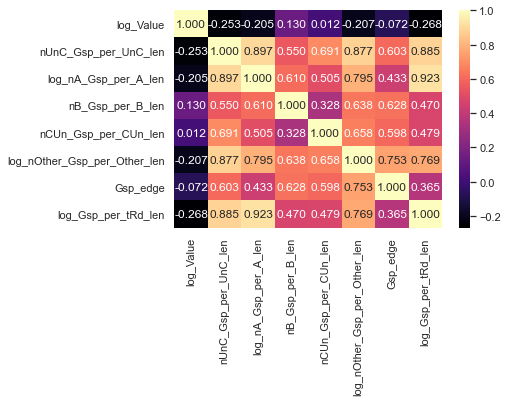

In [65]:
sns.heatmap(hmean_df[['log_Value']+t_var_names].corr().round(4),annot=True,fmt='.3f',cmap='magma')
plt.show()

In [72]:
def get_corr(df,iter_range,method='pearson',features=t_var_names,target='log_Value'):
    result=[]
    for index in iter_range:
        result.append(df.loc[(index,)].corr(method=method).loc[features,target])
    result=np.asarray(result)
    return result

In [67]:
def get_moran(df,iter_range,w=weight,target='log_Value'):
    result=[]
    for index in iter_range:
        result.append(Moran(df.loc[(index,),target].values,w).I)
    return result

In [102]:
def get_cv(reg, features, target, iter=100, splits=3, reshape=False):
    cv_r2 = []
    cv_tau = []

    for i in range(iter):
        kf = KFold(n_splits=splits, shuffle=True, random_state=i)
        cvprd = cross_val_predict(reg, features, target, cv=kf)
        if reshape:
            cvprd = cvprd.reshape(-1)
            target = target.reshape(-1)
    
        r = stats.pearsonr(target,cvprd)[0]
        t, p_value = stats.kendalltau(target, cvprd)
        
        cv_r2.append(r**2)
        cv_tau.append(t)

    return [round(np.mean(cv_r2),5), round(np.std(cv_r2),5), round(np.mean(cv_tau),5), round(np.std(cv_tau),5)]

In [113]:
def get_reg_info(df, iter_range, features=t_var_names, target='log_Value', cv_split=3, reg=LinearRegression()):
    result = []
    for index in iter_range:
        X = df.loc[(index,), features].values        
        y = df.loc[(index,), target].values
        #X = scaler.fit_transform(X)
        
        reg.fit(X, y)
        coef = reg.coef_.tolist()
        cv = get_cv(reg, X, y, splits=cv_split)
        coef = coef + cv
        importance, std = get_importance(reg, X, y, features)
        coef = coef + importance + std
        result.append(coef)
    result = pd.DataFrame(result, columns=features+['cv_r2','r2_std','cv_tau','tau_std']+
                          ['fi_'+var for var in features]+['std_fi_'+var for var in features])
    return result

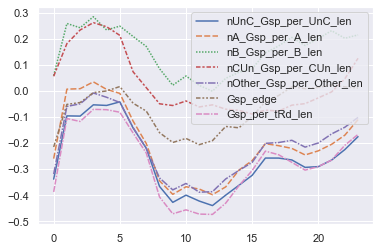

In [74]:
hmean_corr=get_corr(hmean_df,range(24))
sns.lineplot(data=hmean_corr,legend=False)
plt.legend(labels=var_names)
plt.show()

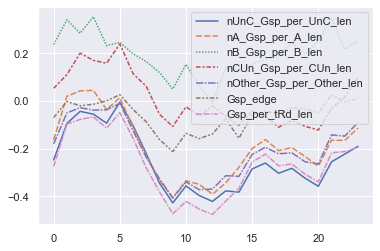

In [75]:
hmean_corr_sp=get_corr(hmean_df,range(24),method='spearman')
sns.lineplot(data=hmean_corr_sp,legend=False)
plt.legend(labels=var_names)
plt.show()

<AxesSubplot:>

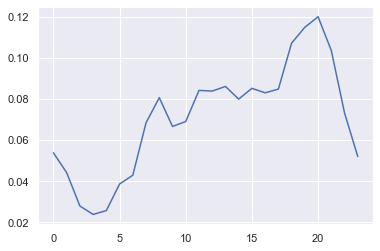

In [76]:
hmean_moran=get_moran(hmean_df,range(24))
sns.lineplot(x=range(24),y=hmean_moran)

<AxesSubplot:>

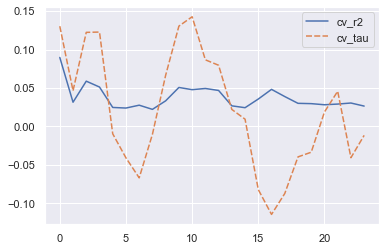

In [78]:
hmean_reg=get_reg_info(hmean_df,range(24), cv_split=3)
sns.lineplot(data=hmean_reg[['cv_r2','cv_tau']])

No handles with labels found to put in legend.


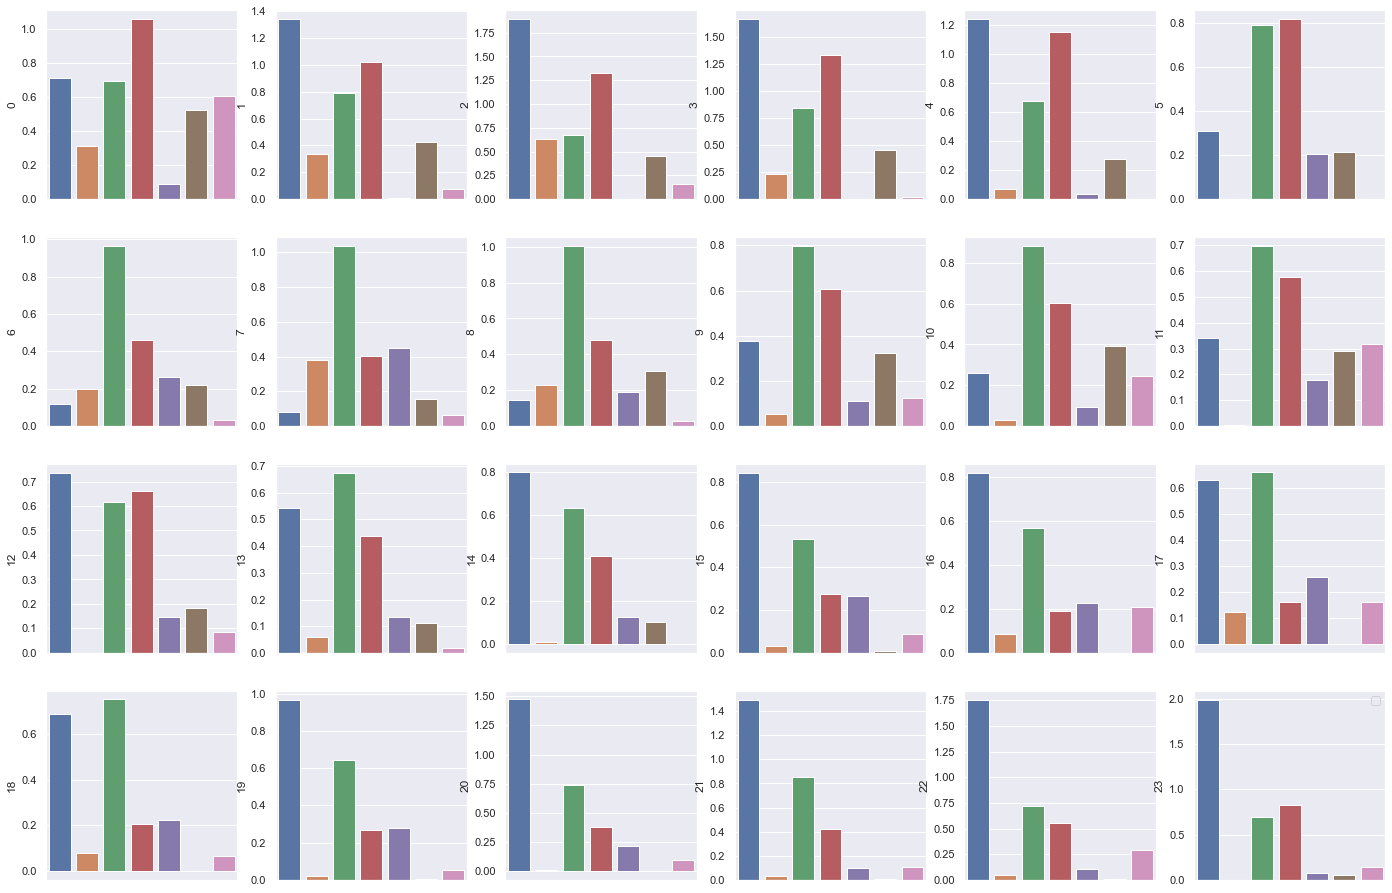

In [80]:
fig, ax = plt.subplots(4, 6, figsize=(24, 16))
i = 0
for hour in range(24):
    g = sns.barplot(x=['fi_' + elem for elem in t_var_names], 
                    y=hmean_reg.loc[hour, ['fi_' + elem for elem in t_var_names]],
                    ax=ax[i//6, i%6])
    g.set(xticklabels=[])
    i += 1
plt.legend()
plt.show()

In [118]:
hmean_x = hmean_df[t_var].values
hmean_y = hmean_df['log_Value'].values

hmean_x = scaler.fit_transform(hmean_x)
hmean_y = hmean_y.reshape(-1, 1)
hmean_y = scaler.fit_transform(hmean_y)

reg.fit(hmean_x, hmean_y)
get_cv(reg, hmean_x, hmean_y, splits=10, reshape=True)


[0.37836, 0.00425, 0.42581, 0.00343]

In [119]:
reg.coef_

array([[-0.30956698, -0.02715361,  0.29107977,  0.27626396, -0.14345939,
        -0.1338562 ,  0.00453786,  0.17038733,  0.4774025 , -0.07640971,
        -0.52776754]])

In [106]:
get_importance(reg, hmean_x, hmean_y, t_var, method='neg_mean_squared_error')

([0.02161,
  0.00012,
  0.0231,
  0.01807,
  0.00373,
  0.00291,
  0.0,
  0.00558,
  0.05685,
  0.00078,
  0.07457],
 [0.00166,
  0.00011,
  0.00178,
  0.00122,
  0.00057,
  0.00045,
  2e-05,
  0.00069,
  0.00311,
  0.00022,
  0.00418])

In [107]:
mmean_df=df.groupby(['month','Site']).mean()
mmean_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 252 entries, (1, 'BL0') to (12, 'TH4')
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Value                         252 non-null    float64
 1   Gsp_area                      252 non-null    float64
 2   Gsp_edge                      252 non-null    float64
 3   nUnC_Gsp_per_UnC_len          252 non-null    float64
 4   nA_Gsp_per_A_len              252 non-null    float64
 5   nB_Gsp_per_B_len              252 non-null    float64
 6   nCUn_Gsp_per_CUn_len          252 non-null    float64
 7   nOther_Gsp_per_Other_len      252 non-null    float64
 8   Gsp_per_tRd_len               252 non-null    float64
 9   bp_mean                       252 non-null    float64
 10  tmp_mean                      252 non-null    float64
 11  prec_mean                     252 non-null    float64
 12  wsp_mean                      252 non-null    f

In [108]:
mmean_df.drop(['hour','dayofweek','dayofmonth'], axis=1, inplace=True)

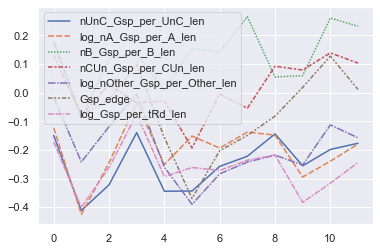

In [109]:
mmean_corr=get_corr(mmean_df,range(1,13))
sns.lineplot(data=mmean_corr,legend=False)
plt.legend(labels=t_var_names,loc='upper left')
plt.show()

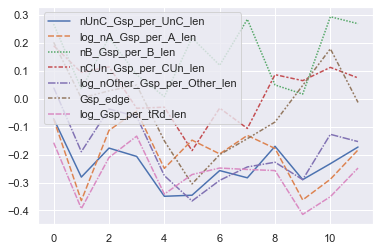

In [110]:
mmean_corr_sp=get_corr(mmean_df,range(1,13),method='spearman')
sns.lineplot(data=mmean_corr_sp,legend=False)
plt.legend(labels=t_var_names,loc='upper left')
plt.show()

<AxesSubplot:>

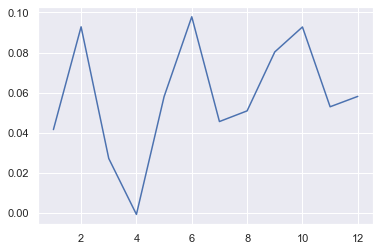

In [111]:
mmean_moran=get_moran(mmean_df,range(1,13))
sns.lineplot(x=range(1,13),y=mmean_moran)

<AxesSubplot:>

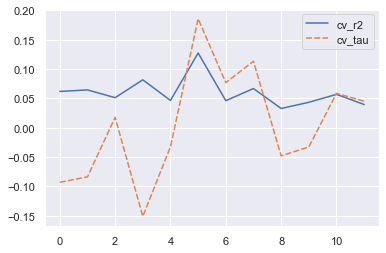

In [114]:
mmean_reg = get_reg_info(mmean_df,range(1,13),cv_split=2)
sns.lineplot(data=mmean_reg[['cv_r2','cv_tau']])

No handles with labels found to put in legend.


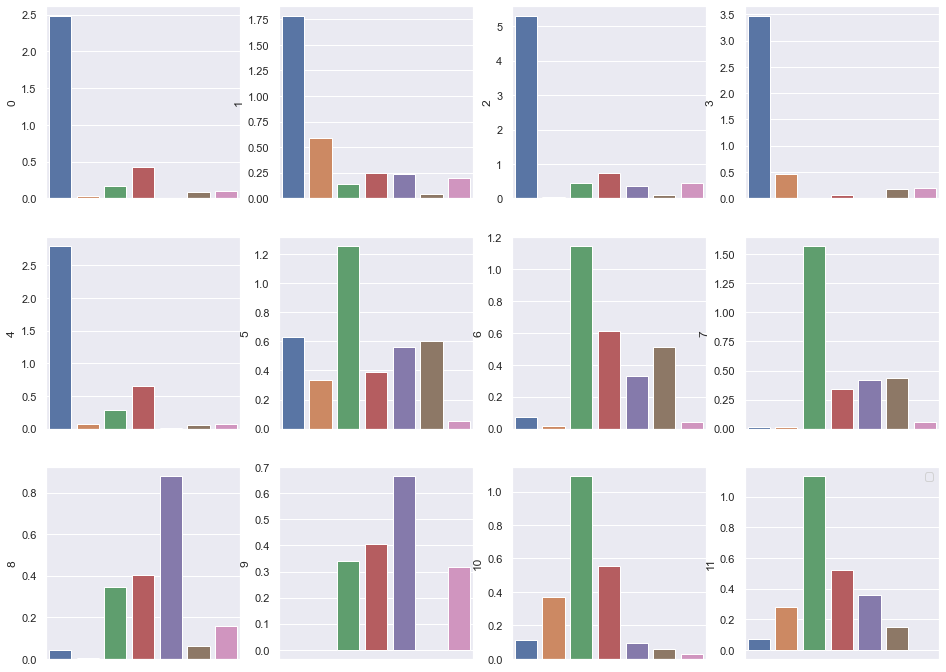

In [116]:
fig, ax = plt.subplots(3, 4, figsize=(16, 12))
i = 0
for month in range(1,13):
    g = sns.barplot(x=['fi_' + elem for elem in t_var_names], 
                    y=mmean_reg.loc[month-1, ['fi_' + elem for elem in t_var_names]],
                    ax=ax[i//4, i%4])
    g.set(xticklabels=[])
    i += 1
plt.legend()
plt.show()

In [120]:
mmean_x = mmean_df[t_var].values
mmean_y = mmean_df['log_Value'].values

mmean_x = scaler.fit_transform(mmean_x)
mmean_y = mmean_y.reshape(-1, 1)
mmean_y = scaler.fit_transform(mmean_y)

reg.fit(mmean_x, mmean_y)
get_cv(reg, mmean_x, mmean_y, splits=10, reshape=True)

[0.20971, 0.00931, 0.32381, 0.00825]

In [121]:
reg.coef_

array([[-0.21193474, -0.01948246,  0.19813736,  0.18824184, -0.09674791,
        -0.0911289 ,  0.00372042,  0.11038215, -0.29735202, -0.00729068,
        -0.04637743]])

In [122]:
get_importance(reg, mmean_x, mmean_y, t_var, method='neg_mean_squared_error')

([0.01008,
  5e-05,
  0.01096,
  0.00837,
  0.0017,
  0.0013,
  0.0,
  0.00159,
  0.01748,
  0.0,
  0.00035],
 [0.00168,
  0.00013,
  0.00194,
  0.00159,
  0.00069,
  0.00057,
  2e-05,
  0.00075,
  0.00223,
  5e-05,
  0.00025])